In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
articles_with_sentiment = pd.read_csv("../data/cleaned-data/articles_with_sentiment.csv")
# Create a 'sentiment' column based on the 'compound' values
articles_with_sentiment['sentiment'] = articles_with_sentiment['compound'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

y=[]
#ITERATE OVER ROWS

for i in range(0,articles_with_sentiment.shape[0]):
    # CONVERT STRINGS TO INT TAGS
    if(articles_with_sentiment["sentiment"][i]=="positive"):
        y.append(1)
    if(articles_with_sentiment["sentiment"][i]=="neutral"):
        y.append(0)
    if(articles_with_sentiment["sentiment"][i]=="negative"):
        y.append(-1)

    if(i<3):
        print(i)
        print(articles_with_sentiment["content"][i].replace("<br />",""),'\n')
        print(articles_with_sentiment["sentiment"][i],y[i])

0
"people have been let off the leash," thomas mayo says quietly, swiping through screenshots racist memes depicting first nations australians as "grifters", "wife beaters" and "primitives" flash ac… [+9064 chars] 

negative -1
1
in 2019 and 2020, a megafire scorched eastern australia, destroying some 24 million hectares of land, and adding to the hole in the ozone layer another massive fire ate away parts of northern califo… [+7274 chars] 

negative -1
2
all a wildfire needs is oxygen, an ignition to spark it, and fuel to burn its crackling embers and flickering flames dont know the difference between the california foothills, where residents are us… [+10837 chars] 

positive 1


In [3]:
# CONVERT Y TO NUMPY ARRAY
y=np.array(y)
#DOUBLE CHECK SIZE
print(len(articles_with_sentiment["content"]),len(y))

98 98


In [11]:
#| echo: false
import requests
import json
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load the JSON data from the file
with open("../data/raw-data/articles.json", "r") as json_file:
    data = json.load(json_file)
    articles = pd.DataFrame(data)

verbose=True

def string_cleaner(input_string):
    out = ''
    try: 
        out=re.sub(r"""
                    [,.;@#?!&$-]+  # Accept one or more copies of punctuation
                    \ *           # plus zero or more copies of a space,
                    """,
                    " ",          # and replace it with a single space
                    input_string, flags=re.VERBOSE)

        #REPLACE SELECT CHARACTERS WITH NOTHING
        out = re.sub('[’.]+', '', input_string)

        #ELIMINATE DUPLICATE WHITESPACES USING WILDCARDS
        out = re.sub(r'\s+', ' ', out)

        #CONVERT TO LOWER CASE
        out=out.lower()
    except:
        print("ERROR")
        out=''
    return out
    
article_keys = articles.columns
print("AVAILABLE KEYS:")
print(article_keys)

index = 0
cleaned_data = []

for _, article in articles.iterrows():
    tmp = []
    if verbose:
        print("#------------------------------------------")
        print("#", index)
        print("#------------------------------------------")

    for key in article_keys:
        if verbose:
            print("----------------")
            print(key)
            print(article[key])  # Access the value directly

        if key == 'source':
            src = string_cleaner(article['source']['name'])
            tmp.append(src)

        if key == 'author':
            author = string_cleaner(article['author'])
            # ERROR CHECK (SOMETIMES AUTHOR IS SAME AS PUBLICATION)
            if src in author:
                print(" AUTHOR ERROR:", author)
                author = 'NA'
            tmp.append(author)

        if key == 'title':
            tmp.append(string_cleaner(article['title']))

        if key == 'description':
            tmp.append(string_cleaner(article['description']))

        if key == 'content':
            tmp.append(string_cleaner(article['content']))

        if key == 'publishedAt':
            # DEFINE DATA PATTERN FOR RE TO CHECK  .* --> wildcard
            ref = re.compile('.*-.*-.*T.*:.*:.*Z')
            date = article['publishedAt']
            if not ref.match(date):
                print(" DATE ERROR:", date)
                date = "NA"
            tmp.append(date)

    cleaned_data.append(tmp)
    index += 1

# Define a filter condition to check for "[removed]" in column 5
filter_condition = lambda article: article[5] != "[removed]"

# Use a list comprehension to create a new cleaned_data list with rows that satisfy the condition
cleaned_data_filtered = [article for article in cleaned_data if filter_condition(article)]

AVAILABLE KEYS:
Index(['source', 'author', 'title', 'description', 'url', 'urlToImage',
       'publishedAt', 'content'],
      dtype='object')
#------------------------------------------
# 0
#------------------------------------------
----------------
source
{'id': 'bbc-news', 'name': 'BBC News'}
----------------
author
https://www.facebook.com/bbcnews
----------------
title
Voice referendum: Lies fuel racism ahead of Australia's Indigenous vote
----------------
description
Experts express concerns for First Nations people as a referendum debate turns increasingly divisive.
----------------
url
https://www.bbc.co.uk/news/world-australia-66470376
----------------
urlToImage
https://ichef.bbci.co.uk/news/1024/branded_news/13D39/production/_130790218_gettyimages-1593394059-1.jpg
----------------
publishedAt
2023-09-05T21:23:49Z
----------------
content
"People have been let off the leash," Thomas Mayo says quietly, swiping through screenshots. 
Racist memes depicting First Nations Austra

In [14]:
def vectorize(corpus,MAX_FEATURES):
    vectorizer=CountVectorizer(max_features=MAX_FEATURES)   
    # RUN COUNT VECTORIZER ON OUR COURPUS 
    Xs=vectorizer.fit_transform(corpus)   
    X=np.array(Xs.todense())
    #CONVERT TO ONE-HOT VECTORS (can also be done with binary=true in CountVectorizer)
    maxs=np.max(X,axis=0)
    return (np.ceil(X/maxs),vectorizer.vocabulary_)
content_data = [article[5] for article in cleaned_data_filtered] 
(x,vocab0)=vectorize(content_data,MAX_FEATURES=500)
# DOUBLE CHECK SHAPES
print(x.shape,y.shape)

(98, 500) (98,)


In [64]:
#swap keys and values (value --> ley)
vocab1 = dict([(value, key) for key, value in vocab0.items()])
# CHECK VOCAB KEY-VALUE PAIRS
print(list(vocab1.keys())[0:10])
print(list(vocab1.values())[0:10])

[340, 190, 81, 234, 296, 453, 232, 460, 249, 417]
['people', 'have', 'been', 'let', 'off', 'the', 'leash', 'thomas', 'mayo', 'says']


In [65]:
# CHECK TO SEE IF COUNT-VECT COLUMNS ARE SORTED BY OCCURRENCE 
print(x.sum(axis=0))
#RE-ORDER COLUMN SO IT IS SORTED FROM HIGH FREQ TERMS TO LOW 
df2=pd.DataFrame(x)
s = df2.sum(axis=0)
df2=df2[s.sort_values(ascending=False).index[:]]
print(df2.head())
# REMAP DICTIONARY TO CORRESPOND TO NEW COLUMN NUMBERS
print()
i1=0
vocab2={}
for i2 in list(df2.columns):
    # print(i2)
    vocab2[i1]=vocab1[int(i2)]
    i1+=1

#DOUBLE CHECK 
print(vocab2[0],vocab1[104])
print(vocab2[1],vocab1[453])

[ 4.  2.  2.  2.  2.  3.  2.  2.  2.  1.  3. 34.  2.  4.  8.  1.  1.  2.
  1.  1.  1.  1.  1.  1.  1.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  3.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  3.  7. 20.  7. 18.  2.  4.
  2.  1.  3.  2.  2. 13.  6. 47.  2.  5.  9.  7.  2.  3.  9.  2.  8.  4.
  2.  5.  2.  2.  2.  2.  3.  2.  2. 11.  6.  2.  4.  2.  2.  2.  4.  1.
  2.  3. 12.  2.  3.  7.  2.  3.  5.  2.  2.  2.  3.  1. 98.  5. 20.  2.
  5.  8.  1.  3.  2.  3.  3.  2.  5.  3.  3.  2.  2.  2.  2.  6.  2.  2.
  3.  3.  2.  2.  5.  2.  5.  2.  3.  2.  3.  6.  2.  1.  2.  4. 19.  3.
  2.  2.  2.  4.  2.  1.  3.  2.  4.  1.  5.  5.  3.  2.  6. 12.  5.  2.
  2.  3.  5.  5.  2.  2.  2. 12.  3.  2.  2.  1.  9.  2.  2.  2.  5.  3.
 18.  2.  2.  3.  5.  3.  2.  2.  2. 21.  8.  2.  7. 21. 14.  5.  5.  2.
  3.  4.  3.  4.  2.  2.  4.  2.  2.  3. 48. 18. 18.  2.  5.  9. 27.  3.
 10.  2.  2.  3.  1.  3.  1.  2.  3.  6.  3. 11.  2. 14.  6.  6.  2.  2.
  2.  2.  3.  2.  2. 20.  3.  1.  5.  2.  4.  3.  2

In [66]:
# RENAME COLUMNS 0,1,2,3 .. 
df2.columns = range(df2.columns.size)
print(df2.head())
print(df2.sum(axis=0))
x=df2.to_numpy()
# DOUBLE CHECK 
print(x.shape,y.shape)

   0    1    2    3    4    5    6    7    8    9    ...  490  491  492  493  \
0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
3  1.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   

   494  495  496  497  498  499  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  1.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 500 columns]
0      98.0
1      73.0
2      48.0
3      48.0
4      48.0
       ... 
495     1.0
496     1.0
497     1.0
498     1.0
499     1.0
Length: 500, dtype: float64
(98, 500) (98,)


In [67]:
print(x)
print(y)

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]]
[-1 -1  1 -1  1  1  1  1  0  0  0 -1 -1  0 -1 -1  1  1 -1  1  1 -1  1 -1
 -1  0 -1  1  0  1 -1  0 -1  0 -1  1 -1  0  1 -1  1 -1 -1 -1 -1 -1 -1 -1
  1 -1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1  0  1 -1 -1  0 -1  0  0  0  0
  0  0 -1  1  0 -1  0  0  0  0  1 -1  1  1 -1 -1  1 -1  1 -1  1  1 -1 -1
 -1 -1]


In [71]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# Chi-Squared Feature Selection
k_best = SelectKBest(score_func=chi2, k=500)  
X_train_selected = k_best.fit_transform(X_train, y_train)
X_test_selected = k_best.transform(X_test)

# Model Building
mnb = MultinomialNB()
mnb.fit(X_train_selected, y_train)

# Model Evaluation
y_pred = mnb.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)

# Get the feature names corresponding to the selected features
selected_feature_indices = k_best.get_support(indices=True)
# Create the selected_features variable using vocab2
selected_features = [vocab2[i] for i in selected_feature_indices]

(98, 500)
(20,)
Accuracy: 0.9
Confusion Matrix:
[[9 0 1]
 [0 5 0]
 [1 0 4]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90        10
           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



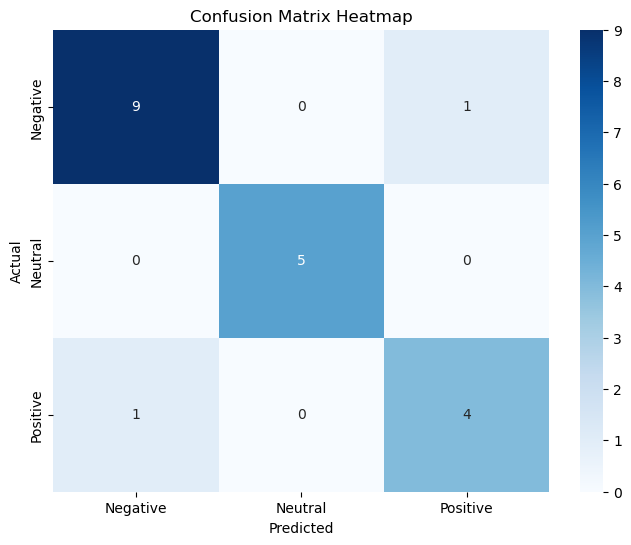

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()
